In [108]:
import sys
import torch
import zipfile as zf
from typing import List, Dict, Tuple

sys.path.append('/Users/mattkingsbury/msccode')
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
with zf.ZipFile('/Users/mattkingsbury/msccode/comp_demos/vincere-vs-og-m2-dust2.dem.zip', 'r') as path:
    path.extractall('/Users/mattkingsbury/msccode/decomp_demos/')

In [110]:
from awpy import DemoParser
from awpy.analytics.stats import player_stats

demo_parser = DemoParser(
    demofile = "/Users/mattkingsbury/msccode/decomp_demos/vincere-vs-og-m2-dust2.dem", 
    demo_id = "navi-og", 
    parse_rate = 128, 
    trade_time = 5, 
    buy_style = "hltv"
)

demo = demo_parser.parse()

In [111]:
from helpers import arr_to_dict, calculate_distance, add_trajectory

teams: List[str] = [None, None]
team1_stats: List[float] = [0.] * 14
team2_stats: List[float] = [0.] * 14
num_rounds: int = 0

# Player Stats
stats_per_player: dict = player_stats(demo["gameRounds"])
for player, stats in stats_per_player.items():
    num_rounds = max(num_rounds, stats['totalRounds'])
    curr_player_team = stats['teamName']
    clutch_successes = sum([stats['success1v1'], stats['success1v1'], stats['success1v1'], stats['success1v1'], stats['success1v1']])
    clutch_attempts = sum([stats['attempts1v1'], stats['attempts1v2'], stats['attempts1v3'], stats['attempts1v4'], stats['attempts1v5']])
    curr_player_stats = [ 
                          stats['kills'], # Kills
                          sum([stats['kills2'], stats['kills3'], stats['kills4'], stats['kills5']]), # Multi-Kills
                          stats['firstKills'], # Entry-Kills
                          stats['totalDamageGiven'], # Damage Dealt
                          stats['totalDamageTaken'], # Damage Taken
                          stats['hsPercent'], # Player Headshot Percentage
                          stats['plants'], # Times Player Planted Bomb
                          stats['defuses'], # Times Player Defused Bomb
                          stats['flashAssists'], # Count Enemies Flashed + Killed By Team While Blind
                          stats['smokesThrown'], # Count Smokes Thrown
                          stats['utilityDamage'], # Total Damage Enemies Received From Player Utility (Grenades, Molotovs)
                          stats['tradeKills'], # Times Player Killed Enemy Immediately After Enemy Killed Teammate
                          clutch_successes / clutch_attempts if clutch_attempts > 0 else None, # Clutch Conversion Probability
                          stats['teamKills'] + stats['suicides'] # Sum (Player Killed Teammate, Player Killed Self) 
                        ]

    # Separate Stats by Team
    if teams[0] == None or teams[0] == curr_player_team: 
        teams[0] = curr_player_team
        team1_stats = list(map(lambda x, y: x + y, curr_player_stats, team1_stats))
    elif teams[1] == None or teams[1] == curr_player_team:
        teams[1] = curr_player_team
        team2_stats = list(map(lambda x, y: x + y, curr_player_stats, team2_stats))

# Sum Team Stats for Bomb and Kill Events
sum_team1_time_to_plant, team1_num_plants, sum_team1_kills_dist, team1_num_kills = 0, 0, 0, 0
sum_team2_time_to_plant, team2_num_plants, sum_team2_kills_dist, team2_num_kills = 0, 0, 0, 0
team1_kills_type: Dict[str, int] = { 'pistols': 0, 'rifle': 0, 'smg': 0, 'heavy': 0 }
team2_kills_type: Dict[str, int] = { 'pistols': 0, 'rifle': 0, 'smg': 0, 'heavy': 0 }
T_side_trajectories:  Dict[str, Dict[int, List[Tuple[float, float]]]] = {}
CT_side_trajectories: Dict[str, Dict[int, List[Tuple[float, float]]]] = {}
for round in demo['gameRounds']:
    for bombEvent in round['bombEvents']:
        if bombEvent['bombAction'] == 'plant':
            if bombEvent['playerTeam'] == teams[0]:
                sum_team1_time_to_plant += bombEvent['seconds']
                team1_num_plants += 1
            else:
                sum_team2_time_to_plant += bombEvent['seconds']
                team2_num_plants += 1
            break
    for killEvent in round['kills']:
        if killEvent['attackerTeam'] == teams[0]:
            if killEvent['weaponClass'] in team1_kills_type:
                team1_kills_type[killEvent['weaponClass']] += 1
            sum_team1_kills_dist += calculate_distance(
                (killEvent['attackerX'], killEvent['attackerY'], killEvent['attackerZ']),
                (killEvent['victimX'], killEvent['victimY'], killEvent['victimZ'])
            )
            team1_num_kills += 1
        else:
            if killEvent['weaponClass'] in team2_kills_type:
                team2_kills_type[killEvent['weaponClass']] += 1
            sum_team2_kills_dist += calculate_distance(
                (killEvent['attackerX'], killEvent['attackerY'], killEvent['attackerZ']),
                (killEvent['victimX'], killEvent['victimY'], killEvent['victimZ'])
            )
            team2_num_kills += 1
    for frames in round['frames']:
        if frames['seconds'] >= 10:
            break
        for team in ['t', 'ct']:
            for player in frames[team]['players']:
                position: Tuple[float, float] = (player['x'], player['y'])
                key: str = player['name'] + ':' + str(player['steamID'])
                add_trajectory(
                            key, 
                            round['roundNum'], 
                            position, 
                            T_side_trajectories if team == 't' else CT_side_trajectories)

# Avg Time For Team To Plant Per Round
avg_team1_plant_time: float = None if team1_num_plants == 0 else sum_team1_time_to_plant / team1_num_plants
avg_team2_plant_time: float = None if team2_num_plants == 0 else sum_team2_time_to_plant / team2_num_plants

# Avg Distance Per Kill For Each Team
avg_team1_kills_dist: float = None if team1_num_kills == 0 else sum_team1_kills_dist / team1_num_kills
avg_team2_kills_dist: float = None if team2_num_kills == 0 else sum_team2_kills_dist / team2_num_kills

# Calculate Avg Team Statistics
team1_stats_pr: List[float] = [
                                *(stat / num_rounds for stat in team1_stats), 
                                avg_team1_plant_time,
                                avg_team1_kills_dist
                              ]
team2_stats_pr: List[float] = [
                                *(stat / num_rounds for stat in team2_stats), 
                                avg_team2_plant_time,
                                avg_team2_kills_dist
                              ]

In [112]:
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from fastdtw import fastdtw
from scipy.spatial.distance import squareform
import numpy as np

# Flattened list of numpy arrays for clustering
trajectories_list: List[np.ndarray] = []
for player in T_side_trajectories:
    for key, value in T_side_trajectories[player].items():
        trajectories_list.append(np.array(value))

# Compute the DTW distance matrix
num_trajectories = len(trajectories_list)
dtw_matrix = np.zeros((num_trajectories, num_trajectories))
for i in range(num_trajectories):
    for j in range(i + 1, num_trajectories):
        distance, _ = fastdtw(trajectories_list[i], trajectories_list[j])
        dtw_matrix[i, j] = distance
        dtw_matrix[j, i] = distance
condensed_dtw_matrix = squareform(dtw_matrix)

# Perform DBSCAN clustering
cluster_dbscan = DBSCAN(
    eps = 2750, 
    min_samples = 2, 
    metric = 'precomputed').fit(dtw_matrix)

# Perform Agglomerative Clustering
cluster_agglomerative = AgglomerativeClustering(
    n_clusters = 5,
    linkage = 'average',
    metric = 'precomputed'
).fit(dtw_matrix)

# Extract Cluster Labels
labels = cluster_dbscan.labels_
arr_to_dict(labels)

{0: 38, 1: 57, 2: 13, 3: 14, -1: 1, 4: 2}

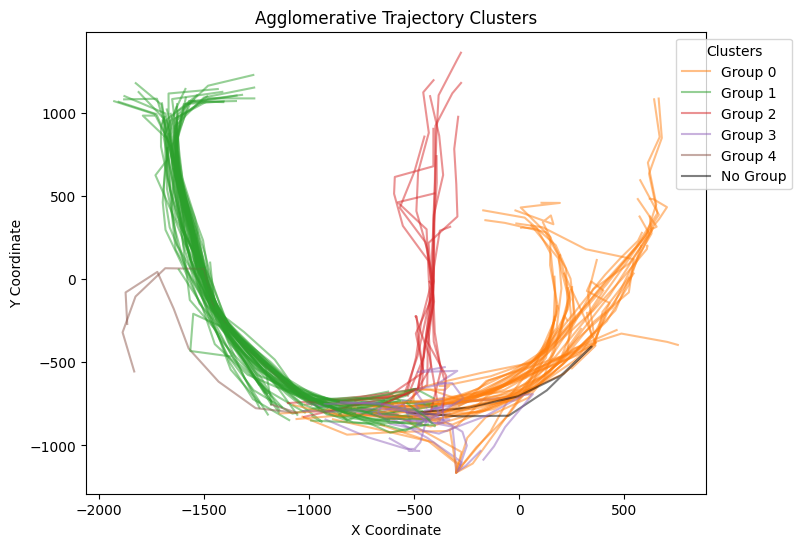

In [113]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))

# Generate distinct colors for clusters
unique_labels = sorted(set(labels))
num_clusters = len(unique_labels)
colors = plt.colormaps.get_cmap('tab10')

# Plot each trajectory with colors based on their cluster labels
for trajectory, label in zip(trajectories_list, labels):
    if label == -1:
        color = 'k'
        label_text = 'No Group'
    else:
        color = colors(unique_labels.index(label))
        label_text = f'Group {label}'
    plt.plot(trajectory[:, 0], 
             trajectory[:, 1], 
             color = color,
             alpha = 0.5, 
             label = label_text if label_text not in plt.gca().get_legend_handles_labels()[1] else "")

# Titles
plt.title('Agglomerative Trajectory Clusters')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')

# Legend
handles, labels = plt.gca().get_legend_handles_labels()
sorted_labels_handles = sorted(zip(labels, handles), key = lambda x: (x[0] != -1, x[0]))
labels, handles = zip(*sorted_labels_handles)
plt.legend(handles, 
           labels, 
           loc = 'upper right',
           bbox_to_anchor = (1.15, 1), 
           ncol = 1, 
           title = "Clusters")

# Show the plot
plt.show()